In [ ]:
import torch
from torch import Tensor
import matplotlib.pyplot as plt
print(torch.__version__)

2.1.0+cu118


In [ ]:
# Install required packages.
%%capture
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

# Link Prediction on MovieLens

This  notebook shows how to load a set of `*.csv` files as input and construct a heterogeneous graph from it.
We will then use this dataset as input into a [heterogeneous graph model](https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html#hgtutorial), and use it for the task of link prediction.
A few code cells require user input to let the code run through successfully.
Parts of this tutorial are also available in [our documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/load_csv.html).

We are going to use the [MovieLens dataset](https://grouplens.org/datasets/movielens/) collected by the GroupLens research group.
This toy dataset describes ratings and tagging activity from MovieLens.
The dataset contains approximately 100k ratings across more than 9k movies from more than 600 users.
We are going to use this dataset to generate two node types holding data for movies and users, respectively, and one edge type connecting users and movies, representing the relation of whether a user has rated a specific movie.

The link prediction task then tries to predict missing ratings, and can, for example, be used to recommend users new movies.

## netwrokx Graph Creation

First, we download the dataset to an arbitrary folder (in this case, the current directory):

In [ ]:
from torch_geometric.data import download_url, extract_zip

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'

Extracting ./ml-latest-small.zip


Before we create the heterogeneous graph, let’s take a look at the data.

> Indented block



In [ ]:
import pandas as pd

print('movies.csv:')
print('===========')
print(pd.read_csv(movies_path)[["movieId", "genres"]].head())
print()
print('ratings.csv:')
print('============')
print(pd.read_csv(ratings_path)[["userId", "movieId"]].head())
print(pd.read_csv(ratings_path).head())


movies.csv:
   movieId                                       genres
0        1  Adventure|Animation|Children|Comedy|Fantasy
1        2                   Adventure|Children|Fantasy
2        3                               Comedy|Romance
3        4                         Comedy|Drama|Romance
4        5                                       Comedy

ratings.csv:
   userId  movieId
0       1        1
1       1        3
2       1        6
3       1       47
4       1       50
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


We see that the `movies.csv` file provides two useful columns: `movieId` assigns a unique identifier to each movie, while the `genres` column represent genres of the given movie.
We can make use of this column to define a feature representation that can be easily interpreted by machine learning models.

In [ ]:
# Load the entire movie data frame into memory:
movies_df = pd.read_csv(movies_path, index_col='movieId')

# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())

# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == (9742, 20)  # 20 genres in total.

         Action  Adventure  Drama  Horror
movieId                                  
1             0          1      0       0
2             0          1      0       0
3             0          0      0       0
4             0          0      1       0
5             0          0      0       0


The `ratings.csv` data connects users (as given by `userId`) and movies (as given by `movieId`).
Due to simplicity, we do not make use of the additional `timestamp` and `rating` information.
Here, we first read the `*.csv` file from disk, and create a mapping that maps entry IDs to a consecutive value in the range `{ 0, ..., num_rows - 1 }`.
This is needed as we want our final data representation to be as compact as possible, *e.g.*, the representation of a movie in the first row should be accessible via `x[0]`.

Afterwards, we obtain the final `edge_index` representation of shape `[2, num_ratings]` from `ratings.csv` by merging mapped user and movie indices with the raw indices given by the original data frame.

In [88]:
# Load the entire ratings data frame into memory:
ratings_df = pd.read_csv(ratings_path)
ratings_df = ratings_df[ratings_df['rating'] >= 3]

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = pd.DataFrame(data={
    'movieId': movies_df.index,
    'mappedID': pd.RangeIndex(len(movies_df)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())

# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)


Mapping of user IDs to consecutive values:
   userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4

Mapping of movie IDs to consecutive values:
   movieId  mappedID
0        1         0
1        2         1
2        3         2
3        4         3
4        5         4


In [93]:
import networkx as nx
import pandas as pd

# Assuming movies_df contains information about movies, unique_movie_id, unique_user_id are obtained as shown earlier
# ratings_df should contain 'userId', 'movieId', and 'rating' columns
# ratings_df = pd.read_csv(ratings_path)

# Create an empty undirected graph
movie_graph = nx.Graph()

# Add nodes for each movie
for movie_id in unique_movie_id['mappedID']:
    # Add nodes with movie ID as the node label
    movie_graph.add_node(movie_id, type='movie')  # Add movie nodes and mark them as 'movie' type

# Add nodes for each user
print(len(unique_user_id))
for user_id in unique_user_id['mappedID']:
    # Add nodes with user ID as the node label
    movie_graph.add_node(user_id, type='user')  # Add user nodes and mark them as 'user' type

# Add edges based on ratings (if ratings_df has 'userId', 'movieId', 'rating' columns)
for idx, row in ratings_df.iterrows():
    user = row['userId']
    movie = row['movieId']
    rating = row['rating']

    # Map original user and movie IDs to the consecutive IDs
    user_mapped_id = unique_user_id[unique_user_id['userId'] == user]['mappedID'].values[0]
    movie_mapped_id = unique_movie_id[unique_movie_id['movieId'] == movie]['mappedID'].values[0]

    # Add an edge between the user and movie nodes
    movie_graph.add_edge(user_mapped_id, movie_mapped_id, weight=rating)





609


In [94]:
# Iterate through nodes and print their attributes to check available attributes
for node, attrs in movie_graph.nodes(data=True):
    print(f"Node {node} attributes: {attrs}")

Streaming output truncated to the last 5000 lines.
Node 4742 attributes: {'type': 'movie'}
Node 4743 attributes: {'type': 'movie'}
Node 4744 attributes: {'type': 'movie'}
Node 4745 attributes: {'type': 'movie'}
Node 4746 attributes: {'type': 'movie'}
Node 4747 attributes: {'type': 'movie'}
Node 4748 attributes: {'type': 'movie'}
Node 4749 attributes: {'type': 'movie'}
Node 4750 attributes: {'type': 'movie'}
Node 4751 attributes: {'type': 'movie'}
Node 4752 attributes: {'type': 'movie'}
Node 4753 attributes: {'type': 'movie'}
Node 4754 attributes: {'type': 'movie'}
Node 4755 attributes: {'type': 'movie'}
Node 4756 attributes: {'type': 'movie'}
Node 4757 attributes: {'type': 'movie'}
Node 4758 attributes: {'type': 'movie'}
Node 4759 attributes: {'type': 'movie'}
Node 4760 attributes: {'type': 'movie'}
Node 4761 attributes: {'type': 'movie'}
Node 4762 attributes: {'type': 'movie'}
Node 4763 attributes: {'type': 'movie'}
Node 4764 attributes: {'type': 'movie'}
Node 4765 attributes: {'type'

In [113]:


# Access all nodes of a specific type (e.g., 'user')
user_nodes = [node for node, data in movie_graph.nodes(data=True) if data['type'] == 'user']

# Access all nodes of another specific type (e.g., 'movie')
movie_nodes = [node for node, data in movie_graph.nodes(data=True) if data['type'] == 'movie']

# # Print nodes of a specific type (e.g., 'user')
# print("User Nodes:")
# for user_node in user_nodes:
#     print(user_node, movie_graph.nodes[user_node])

# Print nodes of another specific type (e.g., 'movie')
print("\nMovie Nodes:")
for movie_node, feature_vector in zip(movie_nodes, movie_feat):
    movie_graph.nodes[movie_node]['features'] = feature_vector.tolist()
    movie_graph.nodes[movie_node]['type'] = 'movie'

for user_node in user_nodes:
    user_feature = torch.tensor([-1] * 20, dtype=torch.float)
    print(user_feature)
    movie_graph.nodes[user_node]['features'] = user_feature.tolist()
    movie_graph.nodes[user_node]['type'] = 'user'



# # Add movie features to the graph nodes
# for movie_id, feature_vector in zip(unique_movie_id['mappedID'], movie_feat):
#     movie_graph.nodes[movie_id]['features'] = feature_vector.tolist()
#     movie_graph.nodes[movie_id]['type'] = 'movie'




Movie Nodes:
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1

In [116]:
# Assuming movie_graph is your NetworkX graph
print("User Node:")
for user_node in user_nodes[:10]:
    print(user_node, movie_graph.nodes[user_node])



User Node:
0 {'type': 'user', 'features': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]}
1 {'type': 'user', 'features': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]}
2 {'type': 'user', 'features': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]}
3 {'type': 'user', 'features': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]}
4 {'type': 'user', 'features': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]}
5 {'type': 'user', 'features': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]}
6 {'type': 'user', 'features': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.

In [112]:
# Get one node of type 'movie'
movie_node = next((n for n, data in movie_graph.nodes(data=True) if data.get('type') == 'movie'), None)
print("\nMovie Node:")
if movie_node:
    print(movie_node, movie_graph.nodes[movie_node])


Movie Node:
609 {'type': 'movie', 'features': [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


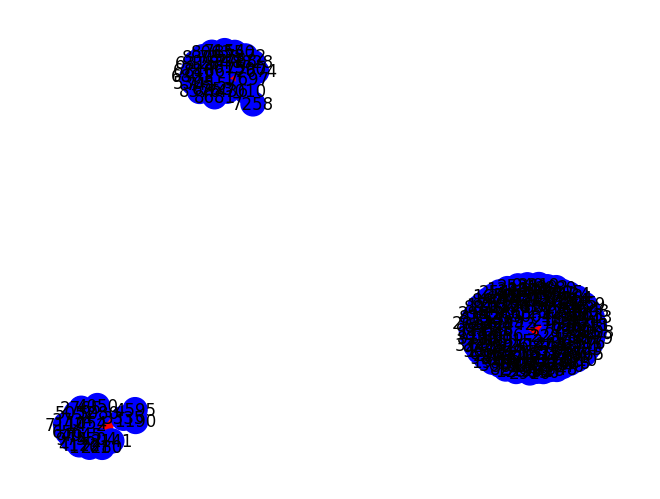

In [117]:

# Define the user nodes (adjust these based on the specific user nodes you want)
selected_user_nodes = [1, 2, 3]  # Example user nodes

# Create an empty subgraph
subgraph = nx.Graph()

# Iterate through the selected user nodes to include their movie node neighbors
for user_node in selected_user_nodes:
    if 'user' in movie_graph.nodes[user_node]['type']:
        # Find the neighboring movie nodes for the current user node
        movie_neighbors = [neighbor for neighbor in movie_graph.neighbors(user_node) if 'movie' in movie_graph.nodes[neighbor]['type']]

        # Add user node to the subgraph
        subgraph.add_node(user_node, type='user')

        # Add movie node neighbors to the subgraph
        subgraph.add_nodes_from(movie_neighbors, type='movie')

        # Add edges between the user node and its movie node neighbors
        subgraph.add_edges_from([(user_node, movie_neighbor) for movie_neighbor in movie_neighbors])

# Draw the subgraph
pos = nx.spring_layout(subgraph, scale = 0.1)  # Positioning the nodes
node_colors = ['b' if subgraph.nodes[node]['type'] == 'movie' else 'r' for node in subgraph.nodes]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors)
plt.show()
# This code snippet iterates through the specified user nodes, identifies their movie node neighbors, and constructs a subgraph including these user nodes and their connected movie nodes. The subgraph is then visualized using NetworkX's draw() function, with nodes colored based on their type (user or movie). Adjust the selected_user_nodes variable to include the specific user nodes you want to focus on in the subgraph visualization.







In [118]:
from sklearn.model_selection import train_test_split

# Splitting edges into training, testing, and validation
edges = list(movie_graph.edges(data=True))

# Extract edge tuples and corresponding edge data (weights/ratings)
edge_tuples = [(u, v) for u, v, d in edges]
edge_data = [d for u, v, d in edges]

# Split the edges and edge data into train/test and validation sets
edge_tuples_train, edge_tuples_val, edge_data_train, edge_data_val = train_test_split(edge_tuples, edge_data, test_size=0.2, random_state=42)
edge_tuples_test, edge_tuples_val, edge_data_test, edge_data_val = train_test_split(edge_tuples_val, edge_data_val, test_size=0.5, random_state=42)

# Create separate graphs for training, testing, and validation
train_graph = movie_graph.copy()
test_graph = movie_graph.copy()
val_graph = movie_graph.copy()

# Remove edges from the respective graphs based on the splits
train_graph.remove_edges_from(edge_tuples_test + edge_tuples_val)
train_graph.remove_edges_from(edge_tuples_val)
test_graph.remove_edges_from(edge_tuples_train + edge_tuples_val)
test_graph.remove_edges_from(edge_tuples_val)
val_graph.remove_edges_from(edge_tuples_train + edge_tuples_test)

# Visualize or use the graphs for training, testing, and validation
# For instance, use these separate graphs for model training and evaluation
# model.fit(train_graph)
# model.evaluate(test_graph)


In [119]:
import networkx as nx
from sklearn.model_selection import train_test_split

# Assuming movie_graph exists with nodes and edges added

# Number of trials or iterations
num_trials = 5  # Change this as needed

# Create arrays to store training, testing, and validation graphs
training_graphs = []
testing_graphs = []
validation_graphs = []

# Convert the graph to an edge list
edge_list = list(movie_graph.edges(data=True))

for i in range(num_trials):
    # Split the edge list into a combined training and testing set and a validation set
    train_test_edges, val_edges = train_test_split(edge_list, test_size=0.2, random_state=i)

    # Further split the combined training and testing set into individual training and testing sets
    train_edges, test_edges = train_test_split(train_test_edges, test_size=0.5, random_state=i)

    # Create a new graph for training and add nodes
    train_graph = nx.Graph()
    train_graph.add_nodes_from(movie_graph.nodes(data=True))

    # Add edges to the training graph
    train_graph.add_edges_from([(u, v, attr) for u, v, attr in train_edges])

    # Append the training graph to the array
    training_graphs.append(train_graph)

    # Create a new graph for testing and add nodes
    test_graph = nx.Graph()
    test_graph.add_nodes_from(movie_graph.nodes(data=True))

    # Add edges to the testing graph
    test_graph.add_edges_from([(u, v, attr) for u, v, attr in test_edges])

    # Append the testing graph to the array
    testing_graphs.append(test_graph)

    # Create a new graph for validation and add nodes
    val_graph = nx.Graph()
    val_graph.add_nodes_from(movie_graph.nodes(data=True))

    # Add edges to the validation graph
    val_graph.add_edges_from([(u, v, attr) for u, v, attr in val_edges])

    # Append the validation graph to the array
    validation_graphs.append(val_graph)


In [120]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv

class GNN(nn.Module):
    def __init__(self, input_user_dim, input_movie_dim, hidden_dim):
        super(GNN, self).__init__()

        # User feature embedding layer
        self.user_embedding = nn.Linear(input_user_dim, hidden_dim)

        # Movie feature embedding layer
        self.movie_embedding = nn.Linear(input_movie_dim, hidden_dim)

        # Heterogeneous graph convolutional layers
        self.conv1 = SAGEConv(hidden_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)

    def forward(self, x, edge_index):
        user_features, movie_features = x

        # Embed user and movie features
        user_embedding = self.user_embedding(user_features)
        movie_embedding = self.movie_embedding(movie_features)

        x = torch.cat([user_embedding, movie_embedding], dim=0)  # Combine user and movie embeddings

        # Apply GNN layers
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)

        return x

# Example dimensions for user and movie features
input_user_dim = 20  # assuming 20 features for users
input_movie_dim = 20  # assuming 20 features for movies
hidden_dim = 64  # dimension of hidden layer

# Initialize GNN model
gnn_model = GNN(input_user_dim, input_movie_dim, hidden_dim)


In [135]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize your GNN model and define your optimizer and loss function
gnn_model = GNN(input_user_dim, input_movie_dim, hidden_dim)
optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    gnn_model.train()
    optimizer.zero_grad()

    # Extract necessary data from the training graph
    node_features = []
    edge_index = []
    edge_ratings = []
    user_features = []
    movie_features = []
    for training_graph in training_graphs:
      for edge in training_graph.edges(data=True):
          u, v, data = edge
          user_features.append(training_graph.nodes[u]['features'])
          movie_features.append(training_graph.nodes[v]['features'])
          edge_index.append((u, v))
          edge_ratings.append(data['weight'])

      user_features_tensor = torch.tensor(user_features, dtype=torch.float)
      movie_features_tensor = torch.tensor(movie_features, dtype=torch.float)
      edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
      edge_ratings_tensor = torch.tensor(edge_ratings, dtype=torch.float)

      # Forward pass - compute predictions
      predicted_edges = gnn_model((user_features_tensor, movie_features_tensor), edge_index_tensor)

      # Calculate loss
      predicted_edges = predicted_edges[::2]
      predicted_ratings = predicted_edges.mean(dim=1)

      loss = criterion(predicted_ratings, edge_ratings_tensor)

      # Backpropagation
      loss.backward()
      optimizer.step()

    # Print loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

# After the training loop, you might want to save the trained model for later use
torch.save(gnn_model.state_dict(), 'trained_gnn_model.pth')


Epoch [1/10], Loss: 15.113875389099121
Epoch [2/10], Loss: 14.501660346984863
Epoch [3/10], Loss: 13.601940155029297
Epoch [4/10], Loss: 12.299823760986328
Epoch [5/10], Loss: 10.604264259338379
Epoch [6/10], Loss: 8.669424057006836
Epoch [7/10], Loss: 6.849459171295166
Epoch [8/10], Loss: 5.623896598815918
Epoch [9/10], Loss: 5.033517837524414
Epoch [10/10], Loss: 4.386443138122559
